## Loading original model

In [1]:
import tensorflow as tf
import pathlib
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
!pwd

/Users/mbp16/Documents/contract_work/packt/tfe_book/git/learn-tensorflow-enterprise/chapter_07/train_reduced_float16_model


In [293]:
root_dir = '/'
model_dir = 'trained_resnet_vector-20200910-213303/save_model'
saved_model_dir = os.path.join(root_dir, model_dir)

In [294]:
saved_model_dir

'/Users/mbp16/Documents/vs_code/python/ScriptProject/trained_resnet_vector-20200910-213303/save_model'

In [295]:
trained_model = tf.saved_model.load(saved_model_dir)

In [296]:
list(trained_model.signatures.keys())

['serving_default']

## Converting full model to TFLite reduced float16 model

Create a converter object from a SavedModel directory.

In [297]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

In [298]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

Save TFLite model

In [299]:
!pwd

/Users/mbp16/Documents/projects


In [288]:
root_dir = '/Users/mbp16/Documents/vs_code/python/ScriptProject'
tflite_models_dir = 'trained_resnet_vector-20200910-213303/tflite_rf16_model'

to_save_tflite_model_dir = os.path.join(root_dir, tflite_models_dir)
saved_tflite_models_dir = pathlib.Path(to_save_tflite_model_dir) #convert string to pathlib object
saved_tflite_models_dir.mkdir(exist_ok=True, parents=True) # make directory

In [300]:
to_save_tflite_model_dir = os.path.join(root_dir, tflite_models_dir)

In [306]:
saved_tflite_model_dir

PosixPath('/Users/mbp16/Documents/vs_code/python/ScriptProject/trained_resnet_vector-20200910-213303/tflite_rf16_model')

In [307]:
tflite_models_dir

'trained_resnet_vector-20200910-213303/tflite_rf16_model'

In [308]:
# Create a pathlib object to save quantized model with path and file name.
tgt = pathlib.Path(to_save_tflite_model_dir, 'converted_model_reduced.tflite')
# Write quantized model to the file.
tgt.write_bytes(tflite_model)

47644960

In [34]:
!ls  /Users/mbp16/Documents/vs_code/python/ScriptProject/trained_resnet_vector-20200910-213303/save_model

assets         saved_model.pb variables


In [28]:
type(saved_tflite_model_dir)

pathlib.PosixPath

In [39]:
import sys
sys.getsizeof('/Users/mbp16/Documents/vs_code/python/ScriptProject/trained_resnet_vector-20200910-213303/save_model/variables')

159

## Scoring using baseline model

Use original model as a baseline. Load original model.

In [50]:
signature_list = list(trained_model.signatures.keys())
signature_list

['serving_default']

In [51]:
infer = trained_model.signatures[signature_list[0]]

In [54]:
type(infer)

tensorflow.python.saved_model.load._WrapperFunction

In [55]:
print(infer.structured_outputs)

{'custom_class': TensorSpec(shape=(None, 5), dtype=tf.float32, name='custom_class')}


### Preparing test data from TFRecord
Loading TFRecord test data

In [56]:
root_dir = '/Users/mbp16/myDocuments/tf_datasets/flower_photos'
test_pattern = "{}/image_classification_builder-test.tfrecord*".format(root_dir)
test_all_files = tf.data.Dataset.list_files( tf.io.gfile.glob(test_pattern))

test_all_ds = tf.data.TFRecordDataset(test_all_files, num_parallel_reads=tf.data.experimental.AUTOTUNE)

Check sample size

In [58]:
sample_size = 0
for raw_record in test_all_ds:
    sample_size += 1
print('Sample size: ', sample_size)

Sample size:  50


Helper function

In [59]:
def decode_and_resize(serialized_example):
    # resized image should be [224, 224, 3] and normalized to value range [0, 255] 
    # label is integer index of class.
    
    parsed_features = tf.io.parse_single_example(
    serialized_example,
    features = {
    'image/channels' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/label' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/text' : tf.io.FixedLenFeature([], tf.string),
    'image/colorspace' : tf.io.FixedLenFeature([], tf.string),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
    })
    image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
    label = tf.cast(parsed_features['image/class/label'], tf.int32)
    label_txt = tf.cast(parsed_features['image/class/text'], tf.string)
    label_one_hot = tf.one_hot(label, depth = 5)
    resized_image = tf.image.resize(image, [224, 224], method='nearest')
    return resized_image, label_one_hot

def normalize(image, label):
    #Convert `image` from [0, 255] -> [0, 1.0] floats 
    image = tf.cast(image, tf.float32) / 255. 
    return image, label

Apply transformation and normalization to TFRecord.

In [60]:
decoded = test_all_ds.map(decode_and_resize)
normed = decoded.map(normalize)

In [61]:
normed

<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.float32)>

Convert TFRecord to numpy array for scoring.

In [64]:
np_img_holder = np.empty((0, 224, 224,3), float)
np_lbl_holder = np.empty((0, 5), int)
for img, lbl in normed:
    r = img.numpy() # image value extracted
    rx = np.expand_dims(r, axis=0) # expand by adding a dimension for batching images.
    lx = np.expand_dims(lbl, axis=0) # expand by adding a dimension for batching labels.
    np_img_holder = np.append(np_img_holder, rx, axis=0) # append each image to create a batch of images.
    np_lbl_holder = np.append(np_lbl_holder, lx, axis=0) # append each one-hot label to create a batch of labels.

Now test data is in numpy format with standardized dimension, pixel value between 0 and 1, and batched. So are labels.

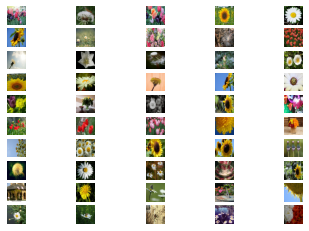

In [68]:
%matplotlib inline
plt.figure()
for i in range(len(np_img_holder)):
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    imshow(np.asarray(np_img_holder[i]))

For single tet file scoring, we need to add a dimension to one sample. Since a given image is of shape (224, 224, 3), we need to make it into (1, 224, 224, 3) so it will be accepted by the model for scoring, as the model is built to handle batch scoring, it is expecting four dimensions with the first dimension being sample size. So let's use the first image in the batch as an example:

In [69]:
x = np.expand_dims(np_img_holder[0], axis=0)

In [70]:
x.shape

(1, 224, 224, 3)

Convert it to a tensor with type of float32

In [74]:
xf = tf.dtypes.cast(x, tf.float32)

### Scoring single image

In [80]:
prediction = infer(xf)

In [86]:
prediction.get('custom_class')

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[1.5271275e-04, 2.0515859e-05, 1.0230409e-06, 2.9591745e-06,
        9.9982280e-01]], dtype=float32)>

In [94]:
predicted_prob_array = prediction.get('custom_class').numpy()

In [97]:
idx = np.argmax(predicted_prob_array)
print(idx)

4


### Mapping prediciton to class name

From TFRecord, I need to create a reverse lookup dictionary to map probability back to label. In other words, I want to find the index where maximum probability is positioned in the array. Map this position index to flower type. To create the lookup dictionary, I need to parse the TFRecord with feature descriptions to extract label indices and names.

In [104]:
feature_description = {
    'image/channels' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/label' :  tf.io.FixedLenFeature([], tf.int64),
    'image/class/text' : tf.io.FixedLenFeature([], tf.string),
    'image/colorspace' : tf.io.FixedLenFeature([], tf.string),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}

def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)

parsd_ds = test_all_ds.map(_parse_function)

val_label_map = {}
# getting label mapping
for image_features in parsd_ds.take(30):
    label_idx = image_features['image/class/label'].numpy()
    label_str = image_features['image/class/text'].numpy().decode()
    if label_idx not in val_label_map:
        val_label_map[label_idx] = label_str

In [105]:
val_label_map

{4: 'tulips', 3: 'dandelion', 1: 'sunflowers', 2: 'daisy', 0: 'roses'}

In [107]:
print(val_label_map.get(idx))

tulips


### Scoring image batch

In [109]:
batched_input = tf.dtypes.cast(np_img_holder, tf.float32)

In [110]:
batch_predicted_prob_array = infer(batched_input)

In [112]:
np_lbl_holder.shape

(50, 5)

In [118]:
np_lbl_holder[:2]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [125]:
actual = []
for i in range(len(np_lbl_holder)):
    class_key = np.argmax(np_lbl_holder[i])
    actual.append(val_label_map.get(class_key))

In [127]:
def lookup(np_entry, dictionary):
    class_key = np.argmax(np_entry)
    return dictionary.get(class_key)

In [135]:
actual = []
for i in range(len(np_lbl_holder)):
    plain_text_label = lookup(np_lbl_holder[i], val_label_map)
    actual.append(plain_text_label)

In [154]:
predicted_label = []
for i in range(sample_size):
    batch_prediction = batch_predicted_prob_array.get('custom_class').numpy()
    plain_text_label = lookup(batch_prediction[i], val_label_map)
    predicted_label.append(plain_text_label)

In [155]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(actual, predicted_label)

In [156]:
print(accuracy)

0.82


## Scoring using quantized model

In [250]:
str(tgt)

'tflite_models/converted_model_reduced.tflite'

In [170]:
##Load the TFLite model and allocate tensors.
## tgt is the pathlib object referring to file path and <TFLITE_MODEL_NAME>.tflite
interpreter = tf.lite.Interpreter(model_path=str(tgt))
interpreter.allocate_tensors()

In [171]:
type(tgt)

pathlib.PosixPath

In [309]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [310]:
input_details[0]['shape']

KeyError: 0

In [192]:
output_details[0]['shape']

array([1, 5], dtype=int32)

In [253]:
input_details

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [254]:
output_details

[{'name': 'Identity',
  'index': 268,
  'shape': array([1, 5], dtype=int32),
  'shape_signature': array([1, 5], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [193]:
# Test the model
input_data = np.array(np.expand_dims(np_img_holder[0], axis=0), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

In [194]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.5181543e-04 2.0090181e-05 1.0022727e-06 2.8991076e-06 9.9982423e-01]]


In [195]:
lookup(output_data, val_label_map)

'tulips'

In [242]:
batch_quantized_prediction = []
for i in range(sample_size):
    input_data = np.array(np.expand_dims(np_img_holder[i], axis=0), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    interpreter_output = interpreter.get_tensor(output_details[0]['index'])
    plain_text_label = lookup(interpreter_output, val_label_map)
    batch_quantized_prediction.append(plain_text_label)

In [244]:
quantized_accuracy = accuracy_score(actual, batch_quantized_prediction)

In [245]:
quantized_accuracy

0.82

For convenience, let's make a function for batch scoring.

In [246]:
def batch_predict(input_raw, input_tensor, output_tensor, dictionary):
    input_data = np.array(np.expand_dims(input_raw, axis=0), dtype=np.float32)
    interpreter.set_tensor(input_tensor[0]['index'], input_data)
    interpreter.invoke()
    interpreter_output = interpreter.get_tensor(output_tensor[0]['index'])
    plain_text_label = lookup(interpreter_output, dictionary)
    return plain_text_label
    

In [247]:
batch_quantized_prediction = []
for i in range(sample_size):
    plain_text_label = batch_predict(np_img_holder[i], input_details, output_details, val_label_map)
    batch_quantized_prediction.append(plain_text_label)

In [248]:
quantized_accuracy = accuracy_score(actual, batched_quantized_prediiction)

In [255]:
print(quantized_accuracy)

0.82
